In [ ]:
#| default_exp describe

# describe

> Use Claude to analyse and describe a given ARC task

This module implements two different strategies for getting Claude to generate a description of a given ARC task.

In [ ]:
#| hide
from nbdev.showdoc import *
import random
from arcsolver.task import train_tasks
import nest_asyncio

In [ ]:
#| hide
random.seed(42)
nest_asyncio.apply()

In [ ]:
#| export
from arcsolver.task import ArcTask, ArcPair
from arcsolver.ocm import Color
from arcsolver.utils import parse_from_xml
from claudette import *
from fastcore.utils import *
from fastcore.meta import *
from anthropic import Anthropic, AsyncAnthropic, AnthropicBedrock, AsyncAnthropicBedrock, AnthropicVertex, AsyncAnthropicVertex
from anthropic.types import Usage
import asyncio
import numpy as np
from dataclasses import dataclass
from typing import Any, List, Dict, Optional
from scipy import ndimage

In [ ]:
#| hide
model = 'us.' + models_aws[1]; model

'us.anthropic.claude-3-5-sonnet-20241022-v2:0'

::: {.content-hidden}

There's a bug in claudette so let's temporarily patch it

:::

In [ ]:
#| export
from toolslm.funccall import get_schema

In [ ]:
#| export
#| hide
@patch
async def __call__(self:AsyncChat,
        pr=None,  # Prompt / message
        temp=0, # Temperature
        maxtok=4096, # Maximum tokens
        stream=False, # Stream response?
        prefill='', # Optional prefill to pass to Claude as start of its response
        **kw):
    await self._append_pr(pr)
    if self.tools: kw['tools'] = [get_schema(o) for o in self.tools]
    res = await self.c(self.h, stream=stream, prefill=prefill, sp=self.sp, temp=temp, maxtok=maxtok, **kw)
    if stream: return self._stream(res)
    self.h += mk_toolres(self.c.result, ns=self.tools)  #, obj=self)
    return res

::: {.content-hidden}

## Strategy 1: Direct descriptions
First, let's construct a system prompt that instructs Claude to analyse an image of an ARC task and generate a description.

:::

In [ ]:
#| export
sp_direct = """\
You are an expert at solving visual IQ puzzles involving transformations between input and output colored grids. \
Your task is to analyze images of puzzles and provide concise, accurate solutions. To solve a given puzzle, follow these steps:

1. INITIAL ANALYSIS
   a) Analyze the input and output grids carefully
   b) Note grid dimensions and any patterns in how they change
   c) Identify if there's a consistent background color
   d) Check if colors maintain consistent meanings across examples

2. ELEMENT IDENTIFICATION
   a) List all elements present in both input and output grids, counting them explicitly
   b) Note whether elements maintain their properties (color, size, shape) across examples
   c) Identify any hierarchical relationships between elements

3. TRANSFORMATION ANALYSIS
   a) Compare input and output grids side by side
   b) Note specific transformations for each element
   c) Analyze whether transformations apply:
      - Globally to the entire grid
      - To individual objects/regions
      - To specific color groups
      - To relationships between objects

4. PATTERN RECOGNITION
   a) Check for symmetry properties:
      - Rotational invariance
      - Mirror symmetry
      - Translation invariance
      - Scale invariance
   b) Look for pattern periodicity or repetition
   c) Analyze edge cases; e.g.:
      - Grid boundary interactions
      - Overlapping objects/patterns

5. CORE KNOWLEDGE PRIORS
   Bear in mind that this class of puzzles are solvable assuming only basic cognitive principles:
   a) Objectness:
      - Object cohesion
      - Object persistence
      - Influence via contact
   b) Goal-directedness (start and end states)
   c) Numbers and Counting (typically <10)
   d) Basic Geometry and Topology:
      - Lines, shapes, and basic geometric properties
      - Symmetries (rotational, mirror, translational)
      - Transformations (rotation, translation, scaling)
      - Spatial relationships and connectivity
      - Pattern periodicity and repetition
   e) Color consistency and meaning
   f) Hierarchical relationships

6. GRID PROPERTIES ANALYSIS
   a) Analyze dimension relationships:
      - Whether input/output dimensions are preserved
      - What determines output dimensions if different
   b) Consider how grid size affects transformation rules
   c) Look for patterns in provided dimension metadata

7. RULE FORMULATION
   a) Develop a general transformation rule
   b) Ensure the rule is:
      - Abstract and applicable to all examples
      - Deterministic (same input always produces same output)
      - Algorithmically implementable
   c) Consider alternative explanations and rule them out
   d) Test rule against edge cases

8. VALIDATION
   a) Double-check rule against all provided examples
   b) Verify rule consistency across different grid sizes
   c) Confirm rule handles all identified edge cases
   d) Refine rule if necessary

Present your thought process in <reasoning> tags. \
This is where you can break down your observations, reasoning, and alternative explanations in detail. \
It's OK for this section to be quite long and to include explicit counting and detailed analysis.

After your analysis, provide a concise solution summary in <description> tags. This summary should:
- Be no more than 4-5 sentences long
- Clearly describe first (in generality) the properties/objects in the input grids
- Then describe properties of the output grids and how an output grid is constructed from its input grid
- Avoid instance-specific descriptions or if-else statements
- Capture all key aspects of the transformation
- Use precise, unambiguous language

Your goal is to provide a clear, concise, and accurate description that captures the essence of the puzzle's \
transformation rule while being general enough to work across all examples. Remember to close xml tags.
"""

Task: ae3edfdc



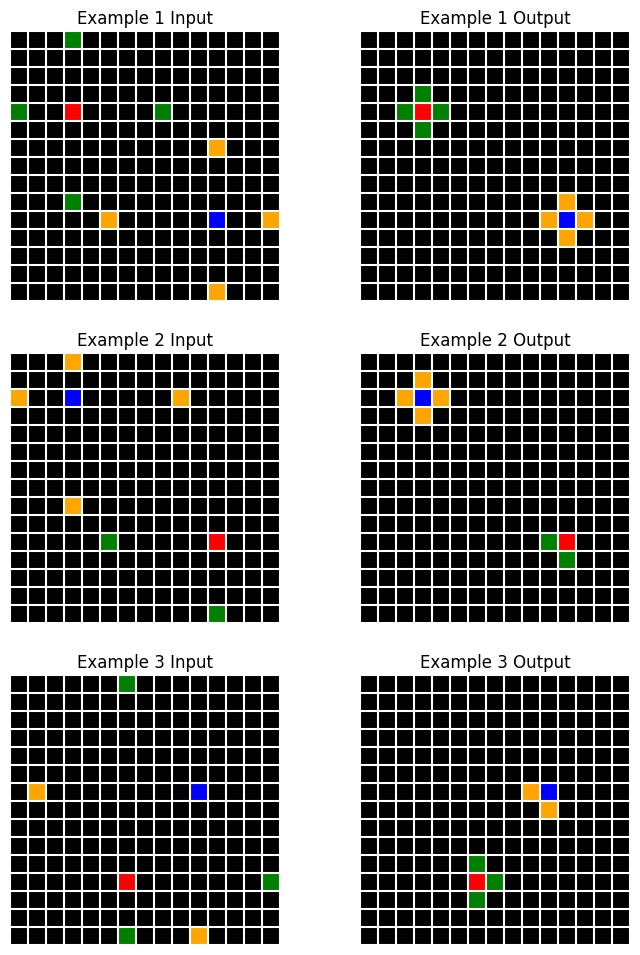

In [ ]:
#| hide
t = random.choice(train_tasks)
task = ArcTask(t)
print(f"Task: {t}\n")
task.plot()

::: {.content-hidden}

Claude often doesn't correctly recognise the dimensions of the grids, so let's pass this as a table in the user prompt

:::


In [ ]:
#| export
def _shape_table(pairs: List[ArcPair]  # List of training example pairs
                ) -> str:              # string containing a table of grid shapes
    header = "| Input Shape | Output Shape |\n|------------|-------------|\n"
    rows = "\n".join(f"| {str(i.shape):<10} | {str(o.shape):<11} |" for i, o in pairs)
    return header + rows

In [ ]:
#| hide
print(_shape_table(task.train))

| Input Shape | Output Shape |
|------------|-------------|
| (15, 15)   | (15, 15)    |
| (15, 15)   | (15, 15)    |
| (15, 15)   | (15, 15)    |


In [ ]:
#| hide
#| eval: false
# Let's try it out

aws_cli = AsyncAnthropicBedrock()
chat = AsyncChat(cli=AsyncClient(model, aws_cli), sp=sp_direct)

pr = f"The example grids in the image have the following shapes:\n{_shape_table(task.train)}"
in_cols = np.unique(np.concatenate([p.input.data for p in task.train]))
out_cols = np.unique(np.concatenate([p.output.data for p in task.train]))
pr += f"\n\nThe colors present in the input grids are: {', '.join(Color.colors[i] for i in in_cols)}.\n"
pr += f"The colors present in the output grids are: {', '.join(Color.colors[i] for i in out_cols)}."

r = await chat([task.plot(to_base64=True), pr], prefill="<reasoning>", temp=0.6)
print(r.content[0].text)

<reasoning>
Let me analyze the patterns carefully:

1. Grid Properties:
- All grids are 15x15
- Black serves as background color
- Colored pixels (blue, red, green, orange) appear to be significant elements

2. Color Analysis:
- Each example has multiple colored pixels
- Colors maintain consistency between input and output
- Colored pixels seem to form clusters in the output

3. Transformation Pattern:
Looking at each example:
Example 1:
- Green pixels cluster near red
- Orange pixels cluster near blue
Example 2:
- Orange pixels cluster together
- Green pixel moves next to red
Example 3:
- Green pixels move next to red
- Orange pixel moves next to blue

Key Observations:
1. Like-colored pixels move together
2. There appears to be a consistent pairing rule:
   - Green pixels always cluster around red pixels
   - Orange pixels always cluster around blue pixels
3. The clustering always results in adjacent positions (sharing edges)
4. When multiple pixels of same color exist, they all move

In [ ]:
#| hide
#| eval: false
chat.cost

0.011484

::: {.content-hidden}

We'll create a container class for storing descriptions and the Claude chats that generated them

:::

In [ ]:
#| export
@dataclass
class Description:
    "A single description of an ARC task."
    content: str            # The full description response (including reasoning)
    chats: List[AsyncChat]  # Store all chats used to generate this description
    method: str             # 'direct' or 'indirect'

    @property
    def d(self) -> str:
        "Extract just the description from the full response"
        return parse_from_xml(self.content, 'description')
    
    @property
    def usage(self) -> Usage:
        "Get combined token usage for this description."
        return sum((chat.use for chat in self.chats), 
                  start=Usage(input_tokens=0, output_tokens=0))
    
    @property 
    def cost(self) -> float:
        "Get total cost in USD for this description."
        return sum(chat.cost for chat in self.chats)

The `Description` class contains the `claudette` chats used to generate the description, the final response content, and the method used ('direct' or 'indirect')

In [ ]:
#| export
def _create_client(client_type,
                   client_kwargs
                  ) -> Union[AsyncAnthropic, AsyncAnthropicBedrock, AsyncAnthropicVertex]:
    "Create appropriate async client based on configuration."
    if client_type == "bedrock":
        return AsyncAnthropicBedrock(**client_kwargs)
    elif client_type == "vertex":
        return AsyncAnthropicVertex(**client_kwargs)
    else:  # default to standard Anthropic
        return AsyncAnthropic(
            default_headers={'anthropic-beta': 'prompt-caching-2024-07-31'},
            **client_kwargs
        )

In [ ]:
#| export
def _create_chat(model, client, sp: str, tools: Optional[list] = None) -> AsyncChat:
    "Create a new chat instance."
    cli = AsyncClient(model, client)
    return AsyncChat(cli=cli, sp=sp, tools=tools)

In [ ]:
#| export
async def _describe_direct(
    task: ArcTask | str,                        # Either an ArcTask object or a task ID string
    model: str = 'claude-3-5-sonnet-20241022',  # Model identifier (defaults to Sonnet 3.5)
    client_type: str = 'anthropic',             # 'anthropic', 'bedrock', or 'vertex'
    client_kwargs: Dict = {},                   # Optional kwargs for client instantiation
    sp: str | None = None,                      # Custom system prompt (if None, uses `sp_direct`)
    temp: float = 0.0,                          # Sampling temperature for generation
    prefill: str = '<reasoning>',               # Text to prefill the assistant's response with
    **kwargs                                    # Additional arguments passed to Chat.__call__
) -> Description:                               # Container holding description and the chat object
    "Generate a description of an ARC task from all examples at once"
    
    if sp is None: sp = sp_direct
    if isinstance(task, str): task = ArcTask(task)

    # Set up chat and get description
    client = _create_client(client_type, client_kwargs)
    chat = _create_chat(model, client, sp)
    
    pr = f"The example grids in the image have the following shapes:\n{_shape_table(task.train)}"
    in_cols = np.unique(np.hstack([p.input.data.flatten() for p in task.train]))
    out_cols = np.unique(np.hstack([p.output.data.flatten() for p in task.train]))
    pr += f"\nThe colors present in the input grids are: {', '.join(Color.colors[i] for i in in_cols)}\n"
    pr += f"\nThe colors present in the output grids are: {', '.join(Color.colors[i] for i in out_cols)}"
    
    r = await chat([task.plot(to_base64=True), pr],
                   prefill=prefill,
                   temp=temp,
                   **kwargs)
    
    return Description(
        content=r.content[0].text,
        chats=[chat],
        method='direct'
    )

In [ ]:
#| hide
#| eval: false
d = await _describe_direct(task, model, 'bedrock', temp=0.4)
print(d.d)

The input grids contain scattered colored pixels (blue, red, green, and orange) on a black background. In the output, pixels are rearranged to form specific color pairings where red pixels become adjacent to green pixels, and blue pixels become adjacent to orange pixels. The total count of each colored pixel remains unchanged between input and output, while the positions of the paired groups can vary within the grid.


::: {.content-hidden}

## Strategy 2: First analyse each example individually, then combine/summarise descriptions

Sometimes it is hard for Claude to accurately identify shapes and patterns from a plot of multiple grids. An alternative approach is to generate descriptions for each example pair independently and then attempt to deduce the common transformation by analysing the set of descriptions.

:::



In [ ]:
#| export
sp_indiv = """\
You are an expert puzzle analyst tasked with deciphering complex visual transformation puzzles. \
You analyze and describe the patterns and distinct shapes contained in input and output grids \
and judge what transformation maps input grids to output grids. 

Analysis Process:
1. INITIAL VISUAL ANALYSIS
   First, analyze the grids visually without tools:
   - Note obvious patterns, shapes, and colors
   - Form initial hypotheses about the transformation
   - Consider whether the transformation appears to be:
     * Global (affecting the entire grid)
     * Local (affecting specific shapes/regions)
     * Pattern-based (involving repetition or rules)
   - Think about why certain changes might occur

2. HYPOTHESIS REFINEMENT
   If your initial analysis leaves uncertainties, consider whether the shape extraction tool would help:
   - For complex or irregular shapes that might be related
   - To verify suspected rotations, reflections, repetitions, or scaling
   - To precisely analyze spatial relationships
   - To confirm pattern hypotheses
   Note that the shape extraction tool can only extract connected regions of a single color; often a "shape" in an ARC task is a distinct multi-colored region.

Use the shape extraction tool judiciously to test specific hypotheses rather than as a first resort. Avoid using it when:
- Shapes are simple and easily describable
- The pattern is clearly global
- The transformation is obvious visually
- Colors appear to be background or noise rather than meaningful shapes

Remember, these puzzles are designed to be solvable using only "Core Knowledge priors":
1. Objectness priors (object cohesion, persistence, and influence via contact)
2. Goal-directedness prior (conceptualize as intentional processes with start/end states)
3. Numbers and Counting priors (quantities typically <10)
4. Basic Geometry and Topology priors (lines, shapes, symmetries, rotations, translations, scaling, spatial relationships)

Present your analysis in this format:

<initial_analysis>
Based on visual inspection:
- Overview of grid properties and obvious patterns
- Initial transformation hypothesis
- Key uncertainties or questions
- Whether tool analysis would be helpful and why
</initial_analysis>

If tool use is required, begin tool-calling process now. \
Once you have gathered the required information via tool calling, proceed with your analys as follows:

<detailed_analysis>
Input:
- Dimensions: [x, y]
- Background: [color if applicable]
- Shapes: [list major shapes with properties and positions]
  * Shape relationships: [note any rotational/reflectional/scaling relationships]
  * Spatial relationships: [relative positions, alignments, groupings]
  * Remember shapes can be multi-colored
- Colors: [list with roles]
- Notable patterns: [recurring elements, global patterns]

Output:
- [Same structure as Input]

Transformations:
- Size changes: [grid or shape scaling]
- Shape changes: [rotations, reflections, splits, merges]
- Color changes: [role changes, new colors, color relationships]
- Position changes: [translations, relative position changes]
- Pattern changes: [how global patterns transform]
</detailed_analysis>

<final_hypothesis>
Provide your final transformation rule hypothesis, considering:
- Whether the transformation is local or global
- What properties are preserved
- Why certain changes occur
- How the transformation aligns with core knowledge priors
- Any remaining uncertainties
</final_hypothesis>

Note: It may not be possible to determine the exact relationship with full confidence. \
Make your best guess considering the points above, and note any uncertainties in your hypothesis. \
Remember to close xml tags.
"""

::: {.content-hidden}

Similar to before, we can generate a user prompt to help Claude perform its analysis. We are also allowing tool use, which is based on colors. To ensure Claude uses the correct color names, we also specify them in the user prompt.

:::

In [ ]:
#| export
def _pair_prompt(pair: ArcPair,  # A single training example pair from an ARC task
                example_idx: int = 0,  # The index of the training example
               ):
    inp, outp = pair
    base_idx = example_idx * 2

    return f"""\
This image contains two grids from a visual IQ puzzle:

input grid (left):
- idx: {base_idx}
- size: {inp.shape[0]}x{inp.shape[1]}
- colors: {', '.join(Color.colors[i] for i in np.unique(inp.data))}

output grid (right):
- idx: {base_idx + 1}
- size: {outp.shape[0]}x{outp.shape[1]}
- colors: {', '.join(Color.colors[i] for i in np.unique(outp.data))}\
"""

In [ ]:
#| hide
pair = task.train[0]
print(_pair_prompt(pair, 0))

This image contains two grids from a visual IQ puzzle:

input grid (left):
- idx: 0
- size: 15x15
- colors: black, blue, red, green, orange

output grid (right):
- idx: 1
- size: 15x15
- colors: black, blue, red, green, orange


::: {.content-hidden}

Claude sometimes incorrectly identifies shapes, or thinks two slightly different shapes are the same. Let's allow Claude to query the shapes in a given grid using tool calling

:::

In [ ]:
#| export
#| hide
class ShapeExtractor:
    """Extract shapes from grid pairs for analysis."""
    def __init__(self, task: ArcTask):
        # Store flattened list of grids in order 
        self.grids = [grid for pair in task.train for grid in pair]
        
    def extract_shapes(
        self,
        grid_idx: int,  # Index of the target grid
        color: str,  # Color of shapes to extract
        include_diagonal: bool,  # Consider diagonally adjacent cells as connected?
    ) -> list:  # List of extracted shapes (boolean arrays) and their positions
        """Extract contiguous regions of a specified color from a grid."""
        ORTH = np.array([[0,1,0], [1,1,1], [0,1,0]])
        DIAG = np.ones((3,3))
        
        try:
            arr = self.grids[grid_idx].data.copy()
        except IndexError as e:
            raise IndexError(f"Invalid grid_index {grid_idx}. Must be between 0 and {len(self.grids)-1}") from e
    
        value = Color.colors.index(color)
        mask = (arr == value)
        structure = DIAG if include_diagonal else ORTH
        labeled, _ = ndimage.label(mask, structure=structure)
        slices = ndimage.find_objects(labeled)
    
        regions = [[np.sum(mask[s]), s, labeled[s] == i+1] for i, s in enumerate(slices)]
        return [(r[2], (r[1][0].start, r[1][1].start)) for r in regions]

::: {.content-hidden}

Claudette implements a `toolloop` function, which allows for multiple exchanges via tool calling until the conversation terminates with a regular text response. We'll implement the same function for the async version of the chat.

:::

In [ ]:
#| export
#| hide
@patch
@delegates(AsyncChat.__call__)
async def toolloop(self:AsyncChat,
             pr, # Prompt to pass to Claude
             max_steps=10, # Maximum number of tool requests to loop through
             trace_func:Optional[callable]=None, # Function to trace tool use steps (e.g `print`)
             cont_func:Optional[callable]=noop, # Function that stops loop if returns False
             **kwargs):
    "Add prompt `pr` to dialog and get a response from Claude, automatically following up with `tool_use` messages"
    n_msgs = len(self.h) - 1
    r = await self(pr, **kwargs)
    for i in range(max_steps):
        if r.stop_reason!='tool_use': break
        if trace_func: trace_func(self.h[n_msgs:]); n_msgs = len(self.h) - 1
        r = await self(**kwargs)
        if not (cont_func or noop)(self.h[-2]): break
    if trace_func: trace_func(self.h[n_msgs:])
    return r

In [ ]:
#| hide
#| eval: false
pair = task.train[1]
extractor = ShapeExtractor(task)
chat = AsyncChat(model, cli=AsyncClient(model, aws_cli), sp=sp_indiv, tools=[extractor.extract_shapes])
r = await chat.toolloop([pair.plot(to_base64=True), pair_prompt(pair, 1)], temp=0.4)

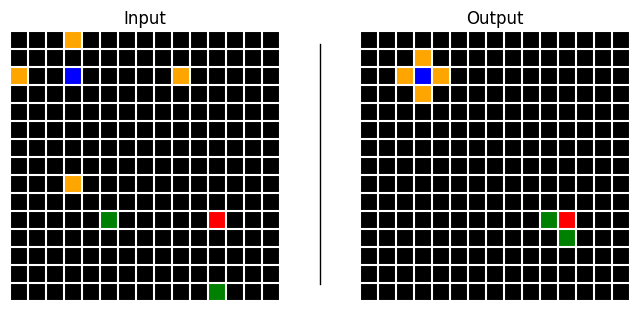

In [ ]:
#| hide
#| eval: false
pair.plot()

In [ ]:
#| hide
#| eval: false
print(r.content[0].text)

<detailed_analysis>
Input:
- Dimensions: 15x15
- Background: black
- Shapes: Single pixels of different colors
  * Blue: 1 pixel at (2,3)
  * Red: 1 pixel at (10,11)
  * Green: 2 pixels at (10,5) and (14,11)
  * Orange: 4 pixels at (0,3), (2,0), (2,9), and (8,3)
- Colors: blue, red, green, orange
- Notable patterns: Scattered single pixels

Output:
- Dimensions: 15x15
- Background: black
- Shapes: Single pixels of different colors
  * Blue: 1 pixel at (2,3)
  * Red: 1 pixel at (10,11)
  * Green: 2 pixels at (10,10) and (11,11)
  * Orange: 4 pixels clustered around (2,3) at (1,3), (2,2), (2,4), and (3,3)

Transformations:
- Blue pixel remains fixed at (2,3)
- Red pixel remains fixed at (10,11)
- Green pixels move closer to the red pixel
- Orange pixels move to form a cross pattern around the blue pixel
</detailed_analysis>

<final_hypothesis>
The transformation appears to follow these rules:
1. Blue and red pixels act as anchor points and remain fixed
2. Orange pixels are attracted to t

::: {.content-hidden}

After we generate descriptions for each example in the task, we can make a separate call instructing Claude to try to infer the general rule from the set of isolated descriptions.

:::

In [ ]:
#| export
sp_merge = """\
You are an expert puzzle analyst tasked with deciphering complex visual transformation puzzles. \
Your goal is to infer the general rule that governs how an input grid is transformed into an output grid \
based on multiple descriptions of individual grid pairs.

The descriptions you'll analyze were generated by observers who each saw only one pair of grids. \
They had access to a shape extraction tool and were instructed to analyze shapes, patterns, and transformations in detail.

Analysis Steps:

1. PATTERN IDENTIFICATION
   For each transformation aspect, analyze across all descriptions:
   - Grid size relationships
   - Shape transformations (rotations, reflections, scaling)
   - Color role patterns
   - Spatial relationship preservation
   - Global vs local patterns

2. CONSISTENCY ANALYSIS
   For each observed pattern, rate:
   - Frequency: How many descriptions support it?
   - Consistency: Are there any contradictions?
   - Completeness: Does it explain all observations?
   - Simplicity: Is it the simplest explanation?

3. TRANSFORMATION CLASSIFICATION
   Determine if transformations are:
   - Local (applying to individual shapes)
   - Global (applying to entire grid)
   - Hierarchical (different rules at different scales)
   - Composite (multiple transformations applied sequentially)

4. RELATIONSHIP ANALYSIS
   Look for patterns in:
   - How shapes relate to each other (rotation, reflection, scaling)
   - How shapes interact with grid boundaries
   - How colors relate to shapes and patterns
   - How relative positions are maintained or changed

5. EDGE CASE CONSIDERATION
   Consider how the rule would handle:
   - Overlapping/touching shapes
   - Shapes at grid boundaries
   - Any other relevant edge cases

Show your analysis process in <reasoning> tags, including:
1. List of all unique characteristics across descriptions
2. Pattern frequency and consistency analysis
3. Alternative hypotheses considered
4. Evidence supporting your chosen rule
5. Potential edge cases and how they're handled

After your analysis, provide a concise solution summary in <description> tags. This summary should:
- Be no more than 4-5 sentences long
- Clearly describe first (in generality) the properties/objects in the input grids
- Then describe properties of the output grids and how an output grid is constructed from its input grid
- Avoid instance-specific descriptions or if-else statements
- Capture all key aspects of the transformation
- Use precise, unambiguous language, i.e. not use terms such as "follows a certain transformation", "according to some rule", etc.

If multiple interpretations are possible, choose the simplest one that explains all observations while respecting these constraints. \
Remember to close xml tags.
"""

In [ ]:
#| export
async def _describe_indirect(
    task: ArcTask | str,                        # Either an ArcTask object or a task ID string
    model: str = 'claude-3-5-sonnet-20241022',  # Model identifier (defaults to Sonnet 3.5)
    client_type: str = 'anthropic',             # 'anthropic', 'bedrock', or 'vertex'
    client_kwargs: Dict = {},                   # Optional kwargs for client instantiation
    sp: str | None = None,                      # Custom system prompt for individual analysis (if None, uses `sp_indiv`)
    sp_combine: str | None = None,              # Custom system prompt for synthesizing from independent descriptions (if None, uses `sp_combine`)
    temp: float = 0.0,                          # Sampling temperature for generation
    tools: Optional[list] = None,               # List of tools to make available to Claude (defaults to `[ShapeExtractor.extract_shapes]`)
    **kwargs                                    # Additional arguments passed to AsyncChat.__call__
) -> Description:                               # Container holding description and the list of chats used
    "Generate a description of an ARC task by analyzing examples independently and then combining insights."

    if isinstance(task, str): task = ArcTask(task)

    # Use default prompts if none provided
    if sp is None: sp = sp_indiv
    if sp_combine is None: sp_combine = sp_merge
    # Create shape extractor
    if tools is None:
        extractor = ShapeExtractor(task)
        tools = [extractor.extract_shapes]
    
    # Create chats for each example pair
    pair_clients = [_create_client(client_type, client_kwargs) for _ in task.train]
    pair_chats = [_create_chat(model, c, sp, tools) for c in pair_clients]
    
    # Process examples concurrently
    pair_tasks = [
        chat.toolloop([pair.plot(to_base64=True), _pair_prompt(pair, i)], temp=temp)
        for i, (chat, pair) in enumerate(zip(pair_chats, task.train))
    ]
    responses = await asyncio.gather(*pair_tasks)

     # Format and merge descriptions
    merge_chat = _create_chat(model, _create_client(client_type, client_kwargs), sp_combine)
    descs = '\n\n'.join(
        f'<description id="{i+1}">\n{r.content[0].text}\n</description>'
        for i, r in enumerate(responses)
    )
    merged = await merge_chat([descs], temp=temp)
    
    # Create description with all chats used
    all_chats = pair_chats + [merge_chat]
    return Description(
        content=merged.content[0].text,
        chats=all_chats,
        method='indirect'
    )

In [ ]:
#| hide
#| eval: false
d_indirect = await describe_indirect(task, model, 'bedrock', temp=0.4)
print(d_indirect.content)

In [ ]:
#| hide
#| eval: false
d_indirect.cost

0.194364

In [ ]:
#| export
class DescriptionGenerator:
    "Generates descriptions of ARC tasks using Claude."
    def __init__(self, 
                 model: str = "claude-3-5-sonnet-20241022",  # Model identifier (defaults to Sonnet 3.5)
                 client_type: str = "anthropic",             # 'anthropic', 'bedrock', or 'vertex'
                 client_kwargs: Optional[Dict] = None,       # Optional kwargs for client instantiation
                 direct_sp: Optional[str] = None,            # Custom system prompt for direct description (if None, uses `sp_direct`)
                 indirect_sp: Optional[str] = None,          # Custom system prompt for single pair description (if None, uses `sp_indiv`)
                 merge_sp: Optional[str] = None):            # Custom system prompt for synthesized description (if None, uses `sp_merge`)
        self.model = model
        self.client_type = client_type
        self.client_kwargs = client_kwargs or {}
        self.direct_sp = direct_sp or sp_direct
        self.indirect_sp = indirect_sp or sp_indiv
        self.merge_sp = merge_sp or sp_merge

    def _create_client(self) -> Union[AsyncAnthropic, AsyncAnthropicBedrock, AsyncAnthropicVertex]:
        "Create appropriate async client based on configuration."
        return _create_client(self.client_type, self.client_kwargs)

    def _create_chat(self, sp: str, tools: Optional[list] = None) -> AsyncChat:
        "Create a new chat instance."
        return _create_chat(self.model, self._create_client(), sp, tools)

## Approach 1: Direct description

The most straightforward approach is to simply provide an image of all examples in a task and ask for a solution description.

We use a system prompt that explains the objective in detail and instructs the model to perform chain of thought reasoning before formulating the final description.

In [ ]:
#| export
@patch
async def describe_direct(
    self: DescriptionGenerator,
    task: ArcTask | str,           # ARC task or task ID to describe
    n: int = 1,                    # No. of descriptions to generate
    temp: float = 0.5,             # Temperature for generation (higher for diversity)
    prefill: str = '<reasoning>',  # Text to prefill the assistant's response with
    **kwargs                       # Additional arguments passed to AsyncChat.__call__
) -> List[Description]:            # List of `Description` objects
    "Generate n direct descriptions of the task concurrently."
    tasks = [
        _describe_direct(task, self.model, self.client_type, self.client_kwargs, self.direct_sp, temp, prefill, **kwargs)
        for _ in range(n)
    ]
    return await asyncio.gather(*tasks)

<br/>Let's demonstrate with an example task:

In [ ]:
#| hide
random.seed(42)

Task: f25fbde4



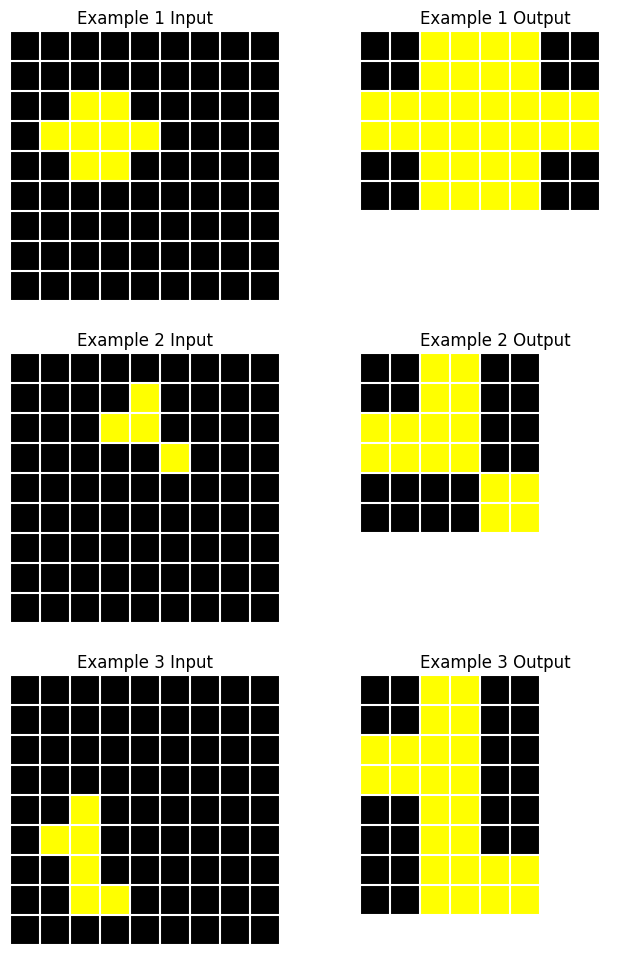

In [ ]:
#| echo: false
t = random.choice(train_tasks)
# t = '1e32b0e9'
task = ArcTask(t)
print(f"Task: {t}\n")
task.plot()

In [ ]:
#| output: false
#| eval: false
describer = DescriptionGenerator(model, 'bedrock')
d_direct = await describer.describe_direct(task)
print(d_direct[0].d)

The input grids contain a pattern of yellow cells on a black background forming a continuous path or shape. The output grid is determined by finding the rectangular region defined by the extremal yellow cells in the input (leftmost, rightmost, topmost, and bottommost). In the output, all cells within this rectangular boundary are filled with yellow, while maintaining black cells outside this region, effectively creating a solid yellow shape that encompasses the original pattern's extent.


In [ ]:
#| echo: false
#| output: asis
#| eval: false
print(f"> {d_direct[0].d}")

> The input grids contain a pattern of yellow cells on a black background forming a continuous path or shape. The output grid is determined by finding the rectangular region defined by the extremal yellow cells in the input (leftmost, rightmost, topmost, and bottommost). In the output, all cells within this rectangular boundary are filled with yellow, while maintaining black cells outside this region, effectively creating a solid yellow shape that encompasses the original pattern's extent.


This description is nearly right. The wording is strange but it seems to have correctly identified that the output is the minimal bounding box around the yellow shape. However, it has not spotted that the yellow shape has been scaled up in size.

This is a common failure mode for Claude. It often erroneously declares that two similar shapes are identical. It can often form a rough idea of what is happening in a task but when faced with multiple similar objects within grids, it fails to identify and distinguish specific shapes. This motivates trying an alternative approach.

## Approach 2: Indirect Description

Instead of presenting the entire task&mdash;which can sometimes feature 5+ pairs of grids&mdash;all at once to Claude, we can instead generate independent descriptions based on individual pairs of grids and subsequently ask Claude to synthesize the information contained in the set of descriptions to form a final unified description.

Pros:

- Larger grids within the image and less whitespace
- Claude can pick out finer details from within the grids
- Can generate highly descriptive summaries of each pair

Cons:

- Many task solutions can not be identified or determined from an isolated example pair
- More token-intensive (expensive)


In [ ]:
#| export
@patch
async def describe_indirect(
    self: DescriptionGenerator,
    task: ArcTask | str,           # ARC task or task ID to describe
    n: int = 1,                    # No. of descriptions to generate
    temp: float = 0.6,             # Temperature for generation (higher for diversity)
    tools: Optional[list] = None,  # List of tools to make available to Claude (defaults to `[ShapeExtractor.extract_shapes]`)
    **kwargs                       # Additional arguments passed to AsyncChat.__call__
) -> List[Description]:            # List of `Description` objects
    "Generate n direct descriptions of the task concurrently."
    tasks = [
        _describe_indirect(task, self.model, self.client_type, self.client_kwargs, self.indirect_sp, self.merge_sp, temp, tools, **kwargs)
        for _ in range(n)
    ]
    return await asyncio.gather(*tasks)

For this approach, we have also implemented tool-use. In order to help Claude accurately identify shapes, we provide a `ShapeExtractor` function that can be used

In [ ]:
show_doc(ShapeExtractor.extract_shapes)

---

[source](https://github.com/jackhogan/arcsolver/blob/main/arcsolver/describe.py#L318){target="_blank" style="float:right; font-size:smaller"}

### ShapeExtractor.extract_shapes

>      ShapeExtractor.extract_shapes (grid_idx:int, color:str,
>                                     include_diagonal:bool)

*Extract contiguous regions of a specified color from a grid.*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| grid_idx | int | Index of the target grid |
| color | str | Color of shapes to extract |
| include_diagonal | bool | Consider diagonally adjacent cells as connected? |
| **Returns** | **list** | **List of extracted shapes (boolean arrays) and their positions** |

In our system prompt, we instruct Claude to generate an intial hypothesis about the task solution, and then use the shape extractor tool to inspect shapes as neccessary to inform its final judgement. Claude can choose how many times to call the function and which colored shapes to extract from which grids. Once it has enough information to form a final description, the conversation ends.

In [ ]:
#| output: false
#| eval: false
d_indirect = await describer.describe_indirect(task)
print(d_indirect[0].d)

The input grid is a 9x9 black grid containing yellow pixels arranged in various patterns. The transformation converts each yellow pixel in the input into a 2x2 block of yellow pixels in the output, while maintaining the relative spatial relationships between yellow elements. The output grid dimensions are reduced to accommodate the transformed pattern while preserving the black background. This transformation creates a blocky, enlarged version of the original pattern in a smaller grid, with the final dimensions adjusted to fit the transformed elements efficiently.


In [ ]:
#| echo: false
#| output: asis
#| eval: false
print(f"> {d_indirect[0].d}")

> The input grid is a 9x9 black grid containing yellow pixels arranged in various patterns. The transformation converts each yellow pixel in the input into a 2x2 block of yellow pixels in the output, while maintaining the relative spatial relationships between yellow elements. The output grid dimensions are reduced to accommodate the transformed pattern while preserving the black background. This transformation creates a blocky, enlarged version of the original pattern in a smaller grid, with the final dimensions adjusted to fit the transformed elements efficiently.


Using this method, it has generated a much more accurate description of the task. We can inspect the chat history to see its use of the tool:

In [ ]:
#| eval: false
print(d_indirect[0].chats[1].h[1]['content'][0].text)

<initial_analysis>
Based on visual inspection:
- Input grid shows a sparse diagonal-like pattern of yellow pixels on black background
- Output grid appears to show a more concentrated arrangement of yellow pixels
- The output grid is smaller (6x6 vs 9x9)
- Initial hypothesis: The yellow pixels might be getting "compressed" into a smaller space while maintaining some kind of pattern
- Key uncertainty: Whether the yellow pixels form a specific connected shape that's being transformed
- Tool analysis would be helpful to:
  * Verify if the yellow pixels form a connected shape in either grid
  * Count exact number of yellow pixels to see if they're preserved
</initial_analysis>

Let me extract the yellow shapes from both grids:


In [ ]:
#| eval: false
d_indirect[0].chats[1].h[1]['content'][1]

ToolUseBlock(id='toolu_bdrk_01UsGpZS8zyEW238PbE3tZDg', input={'grid_idx': 2, 'color': 'yellow', 'include_diagonal': True}, name='extract_shapes', type='tool_use')

::: {.callout-warning}
Note that the indirect method is significantly more expensive than the direct method. It creates separate chat instances for each pair of grids, including an image and triggering a multi-turn tool-calling conversation.
:::


In [ ]:
#| eval: false
print(f"Direct cost: ${d_direct[0].cost:.3f}")
print(f"Indirect cost: ${d_indirect[0].cost:.3f}")

Direct cost: $0.012
Indirect cost: $0.101


In [ ]:
#| export
@patch
async def describe_task(
    self: DescriptionGenerator,
    task: ArcTask | str,           # ARC task or task ID to describe
    n_direct: int = 1,             # No. of direct descriptions to generate
    n_indirect: int = 1,           # No. of indirect descriptions to generate
    temp: float = 0.7,             # Temperature for generation (higher for diversity)
    **kwargs
) -> List[Description]:            # List of `Description` objects  
    "Generate multiple descriptions of a task using one or both strategies concurrently."

    # Generate all descriptions concurrently
    descriptions = await asyncio.gather(
        self.describe_direct(task, n=n_direct, temp=temp, prefill=None, **kwargs),
        self.describe_indirect(task, n=n_indirect, temp=temp, tools=None, **kwargs)
    )

    return [d for d_list in descriptions for d in d_list]

This method allows us to generate descriptions using either or both strategies at the same time.

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()